In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
import time
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [2]:
%%time
lpmt_hits = pd.read_hdf('train_lpmt_hits.h5')
lpmt_n_hits = pd.read_csv('train_lpmt_n_hits.csv')
spmt_hits = pd.read_hdf('train_spmt_hits.h5')
spmt_n_hits = pd.read_csv('train_spmt_n_hits.csv')
spmt_pos = pd.read_csv('spmt_pos.csv')
lpmt_pos = pd.read_csv('lpmt_pos.csv')
info = pd.read_csv('train_info.csv')

Wall time: 1min 50s


#### Large detectors, hits

In [3]:
print(lpmt_hits.head())
print(lpmt_hits.shape)

   event     hitTime   isDN  pmtID
0      0  249.992615  False  14175
1      0   40.010311  False  17319
2      0  162.123199  False  16882
3      0   51.875614  False  14951
4      0   79.817497  False  10947
(92717003, 4)


#### Small detectors, hits

In [4]:
print(spmt_hits.head())
print(spmt_hits.shape)

   event     hitTime   isDN   pmtID
0      0  238.278091  False  311819
1      0  103.316055  False  307244
2      0  108.034225  False  323230
3      0   36.505154  False  320568
4      0   34.109840  False  316487
(2314146, 4)


#### Small detectors, number of hits in event

In [5]:
print(spmt_n_hits.head())
print(spmt_n_hits.shape)

   event_id  nHits
0         0    212
1         1    191
2         3    162
3         4    180
4         5    310
(10000, 2)


#### Large detectors, number of hits in event

In [6]:
print(lpmt_n_hits.head())
print(lpmt_n_hits.shape)

   event_id  nHits
0         0   8902
1         1   7305
2         3   6718
3         4   5966
4         5  12744
(10000, 2)


#### Predictable events

In [7]:
print(info.head())
print(info.shape)

          E          R  evtID           x           y            z
0  4.747791  14610.378      0   8290.7790  11995.6180    911.74286
1  3.919721  14630.141      1  11397.6320   5407.4497  -7409.08200
2  3.765940  16820.080      3  -2377.9307 -16317.7020   3315.59030
3  3.217473  13026.938      4  -8617.1170    868.5116   9730.98600
4  7.360527  15190.775      5   4050.2210   9521.7620  11121.66500
(10000, 6)


#### Position of small detectors

In [8]:
print(spmt_pos.head())
print(spmt_pos.shape)

   pmt_id         pmt_x       pmt_y      pmt_z
0  300000  1.384810e+03   244.17944  19148.438
1  300001  1.217782e+03   703.08670  19148.438
2  300002  9.038709e+02  1077.19130  19148.438
3  300003  4.809396e+02  1321.37070  19148.438
4  300004  8.610328e-14  1406.17330  19148.438
(24952, 4)


#### Position of large detectors

In [9]:
print(lpmt_pos.head())
print(lpmt_pos.shape)

   pmt_id         pmt_x      pmt_y     pmt_z
0       0  1.049021e+03     0.0000  19171.32
1       1  9.084785e+02   524.5103  19171.32
2       2  5.245103e+02   908.4785  19171.32
3       3  6.423399e-14  1049.0206  19171.32
4       4 -5.245103e+02   908.4785  19171.32
(17739, 4)


In [10]:
spmt_n_hits.rename(index = str, columns = {"event_id": "event"}, inplace = True)
lpmt_n_hits.rename(index = str, columns = {"event_id": "event"}, inplace = True)

In [11]:
info.rename(index = str, columns = {"evtID": "event"}, inplace = True)

In [12]:
spmt_n_hits.head()

,event,nHits
0,0,212
1,1,191
2,3,162
3,4,180
4,5,310


In [13]:
%%time
spmt_pos.rename(index = str, columns = {"pmt_id": "pmtID"}, inplace = True)
lpmt_pos.rename(index = str, columns = {"pmt_id": "pmtID"}, inplace = True)

Wall time: 33 ms


In [14]:
%%time
lpmt_hits['isDN'] = lpmt_hits.isDN.apply(lambda x: 0 if x == False else 1)
spmt_hits['isDN'] = spmt_hits.isDN.apply(lambda x: 0 if x == False else 1)

Wall time: 1min 56s


In [28]:
#lpmt_hits.drop(columns = 'is_DN', inplace = True)
#spmt_hits.drop(columns = 'is_DN', inplace = True)

#### Делаю небольшой срез массива хитов, чтобы при мёрдже не завис

In [16]:
lpmt_hits_small = lpmt_hits.loc[lpmt_hits['event'] <= 1200]
print(lpmt_hits.shape)
print(lpmt_hits_small.shape)
print(lpmt_hits_small.head())

(92717003, 4)
(7658346, 4)
   event     hitTime  isDN  pmtID
0      0  249.992615     0  14175
1      0   40.010311     0  17319
2      0  162.123199     0  16882
3      0   51.875614     0  14951
4      0   79.817497     0  10947


In [17]:
pmt = pd.merge(lpmt_hits_small,lpmt_n_hits, how = 'inner', on = 'event')

In [19]:
print(pmt.head())
print(pmt.shape)

   event     hitTime  isDN  pmtID  nHits
0      0  249.992615     0  14175   8902
1      0   40.010311     0  17319   8902
2      0  162.123199     0  16882   8902
3      0   51.875614     0  14951   8902
4      0   79.817497     0  10947   8902
(7658346, 5)


In [20]:
lpmt = pd.merge(pmt, lpmt_pos, on = 'pmtID', how = 'inner')

In [21]:
print(lpmt.head())
print(lpmt.shape)

   event     hitTime  isDN  pmtID  nHits     pmt_x      pmt_y      pmt_z
0      0  249.992615     0  14175   8902 -5411.832  16838.455 -7471.1797
1      0   92.820419     0  14175   8902 -5411.832  16838.455 -7471.1797
2      5  225.598312     0  14175  12744 -5411.832  16838.455 -7471.1797
3      5  -99.477516     1  14175  12744 -5411.832  16838.455 -7471.1797
4     22  311.370026     0  14175  12466 -5411.832  16838.455 -7471.1797
(7658346, 8)


#### Среднее количество шума в каждом из событий

In [22]:
lpmtDN = lpmt.groupby(by = 'event', as_index = False)['isDN'].mean()
print(lpmtDN.head())

   event      isDN
0      0  0.082453
1      1  0.105544
2      3  0.102263
3      4  0.117332
4      5  0.056890


In [23]:
lpmtDN.max()

event    1200.00000
isDN        0.37099
dtype: float64

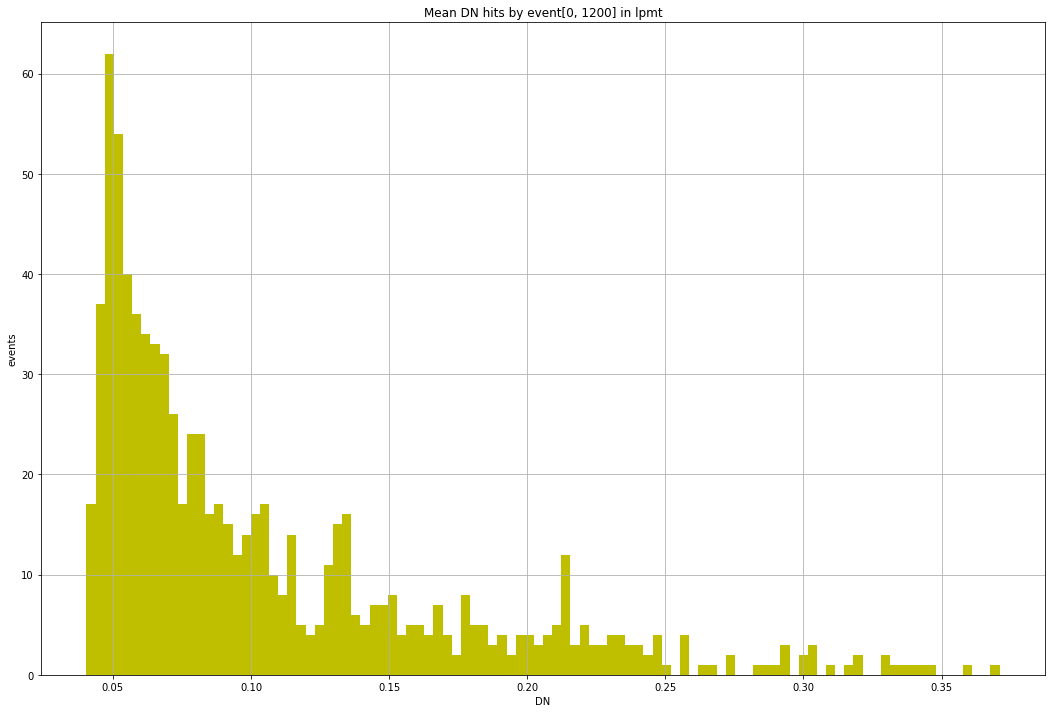

In [25]:
figSize = (18, 12)
plt.figure(figsize = figSize)
plt.grid('on')
plt.hist(lpmtDN['isDN'], bins = 100, color = 'y')
plt.xlabel('DN')
plt.ylabel('events')
plt.title('Mean DN hits by event[0, 1200] in lpmt')
plt.show()

In [27]:
lpmtDN['is_DN'] = lpmtDN.isDN.apply(lambda x: round(x, 2))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

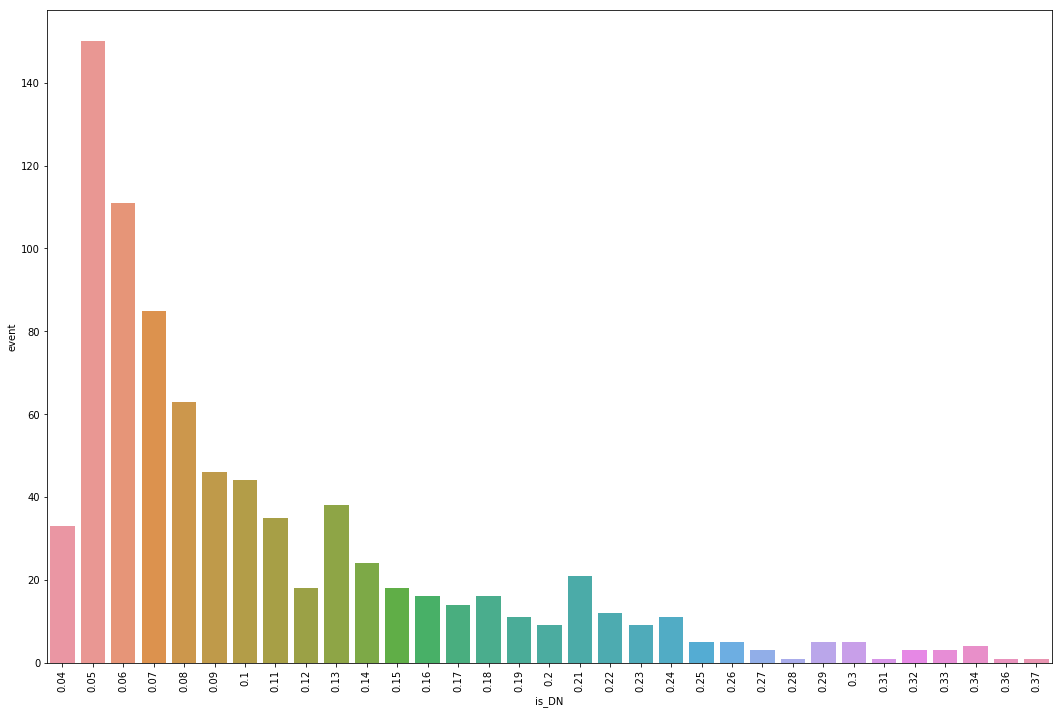

In [30]:
plt.figure(figsize = figSize)
sns.barplot(x = "is_DN", y = "event", data = lpmtDN.groupby('is_DN', as_index = False)['event'].count())
plt.xticks(rotation = 'vertical')

In [ ]:
# Не запускать, виснет!
#pmt = pd.merge(lpmt_hits,lpmt_n_hits, how = 'inner', on = 'event')
#lpmt = pd.merge(pmt, lpmt_pos, on = 'pmtID', how = 'inner')

#### Рассмотрю данные в маленьких детекторах, потому что там их меньше

In [31]:
spmt = pd.merge(spmt_hits,spmt_n_hits, how = 'inner', on = 'event')
print(spmt.head())

   event     hitTime  isDN   pmtID  nHits
0      0  238.278091     0  311819    212
1      0  103.316055     0  307244    212
2      0  108.034225     0  323230    212
3      0   36.505154     0  320568    212
4      0   34.109840     0  316487    212


In [32]:
spmtPos = pd.merge(spmt, spmt_pos, on = 'pmtID', how = 'inner')
print(spmtPos.head())
print(spmtPos.shape)

   event     hitTime  isDN   pmtID  nHits      pmt_x      pmt_y      pmt_z
0      0  238.278091     0  311819    212  1320.0306 -17951.344  6681.8247
1     73  108.962761     0  311819    362  1320.0306 -17951.344  6681.8247
2    232   97.140427     0  311819    429  1320.0306 -17951.344  6681.8247
3    689  143.792679     0  311819    184  1320.0306 -17951.344  6681.8247
4    723  104.973770     0  311819    300  1320.0306 -17951.344  6681.8247
(2314146, 8)


In [34]:
spmtDN = spmt.groupby(by = 'event', as_index = False)['isDN'].mean()
print(spmtDN.head())

   event      isDN
0      0  0.042453
1      1  0.047120
2      3  0.129630
3      4  0.127778
4      5  0.048387


#### Plotting distribution mean amount of events by Dark Noise 

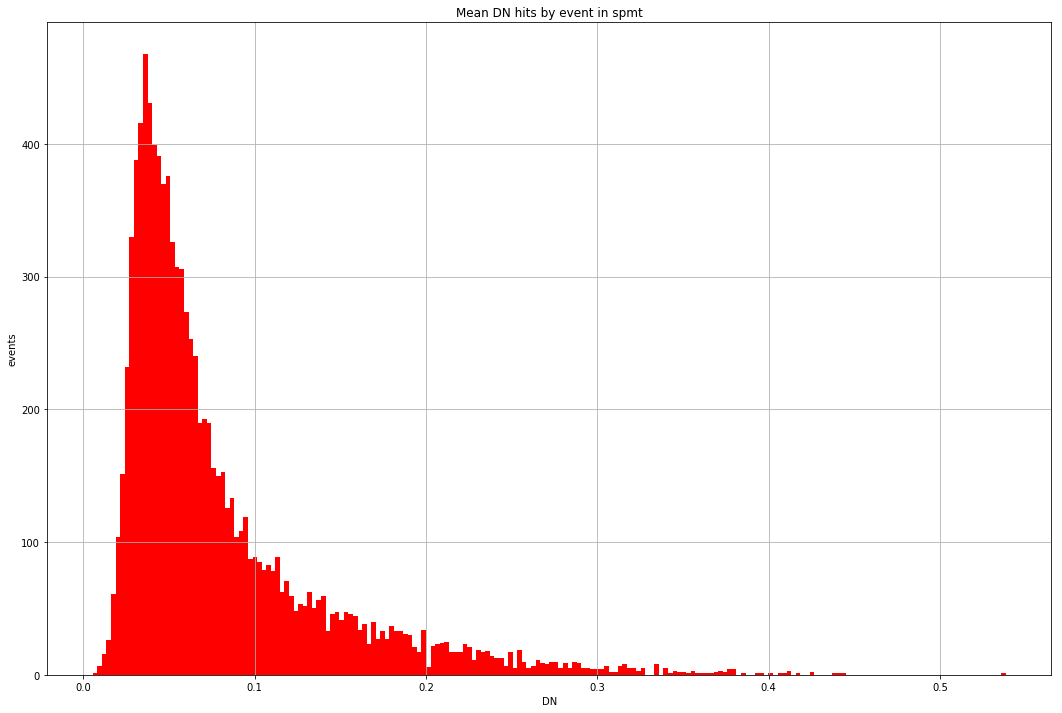

In [35]:
figSize = (18, 12)
plt.figure(figsize = figSize)
plt.grid('on')
plt.hist(spmtDN['isDN'], bins = 200, color = 'r')
plt.xlabel('DN')
plt.ylabel('events')
plt.title('Mean DN hits by event in spmt')
plt.show()

#### Распределение среднего количества шума по событиям

In [36]:
spmtPMT = spmt.groupby(by = 'pmtID', as_index = False)['isDN'].mean()
print(spmtPMT.head())

    pmtID      isDN
0  300000  0.050505
1  300001  0.084337
2  300002  0.031579
3  300003  0.026316
4  300004  0.044118


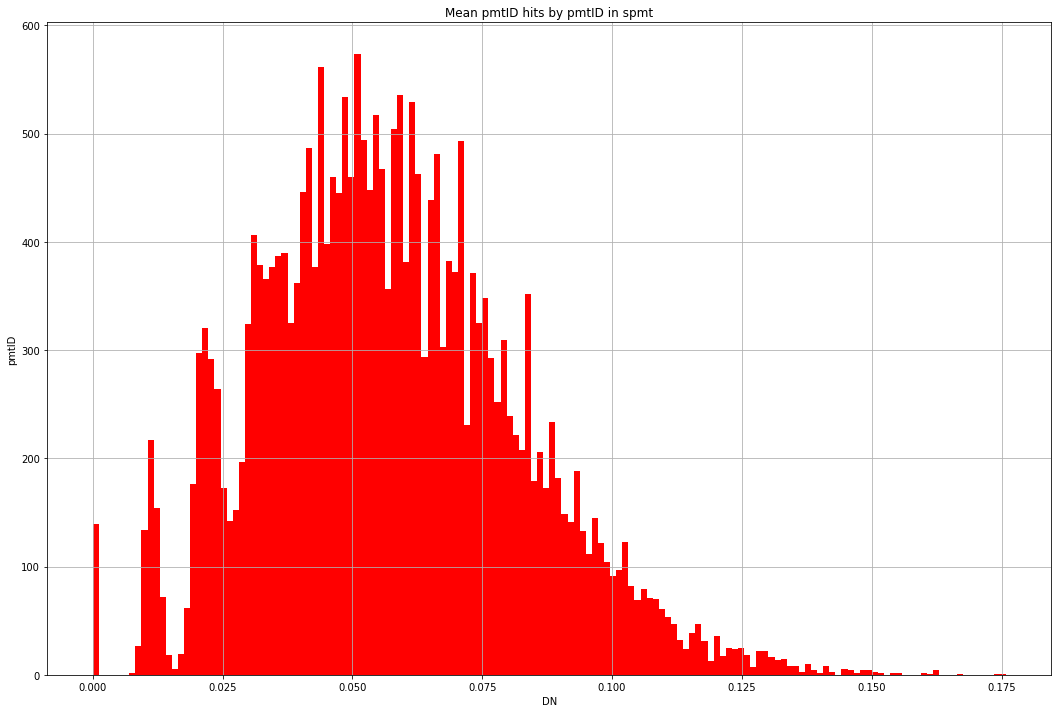

In [30]:
figSize = (18, 12)
plt.figure(figsize = figSize)
plt.grid('on')
plt.hist(spmtPMT['isDN'], bins = 150, color = 'r')
plt.xlabel('DN')
plt.ylabel('pmtID')
plt.title('Mean pmtID hits by pmtID in spmt')
plt.show()

In [37]:
spmtDN['is_DN'] = spmtDN.isDN.apply(lambda x: round(x, 2))
spmtPMT['is_DN'] = spmtPMT.isDN.apply(lambda x: round(x, 2))

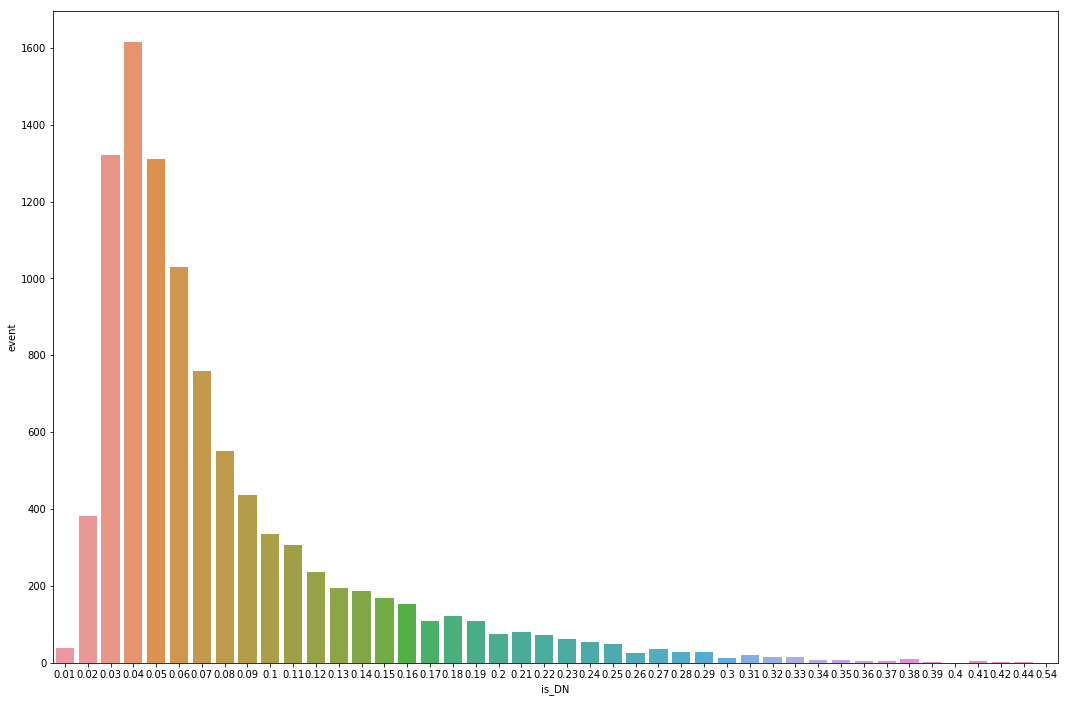

In [38]:
plt.figure(figsize = figSize)
sns.barplot(x = "is_DN", y = "event", data = spmtDN.groupby('is_DN', as_index = False)['event'].count())

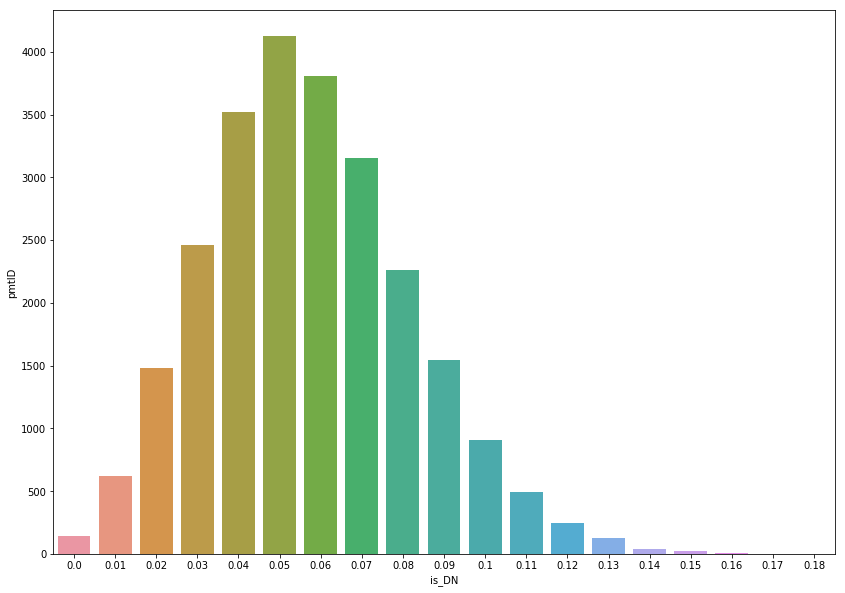

In [45]:
plt.figure(figsize = (14,10))
sns.barplot(x = "is_DN", y = "pmtID", data = spmtPMT.groupby('is_DN', as_index = False)['pmtID'].count())

In [37]:
spmtPMTMean = spmt.groupby('pmtID', as_index = False)['isDN'].mean()

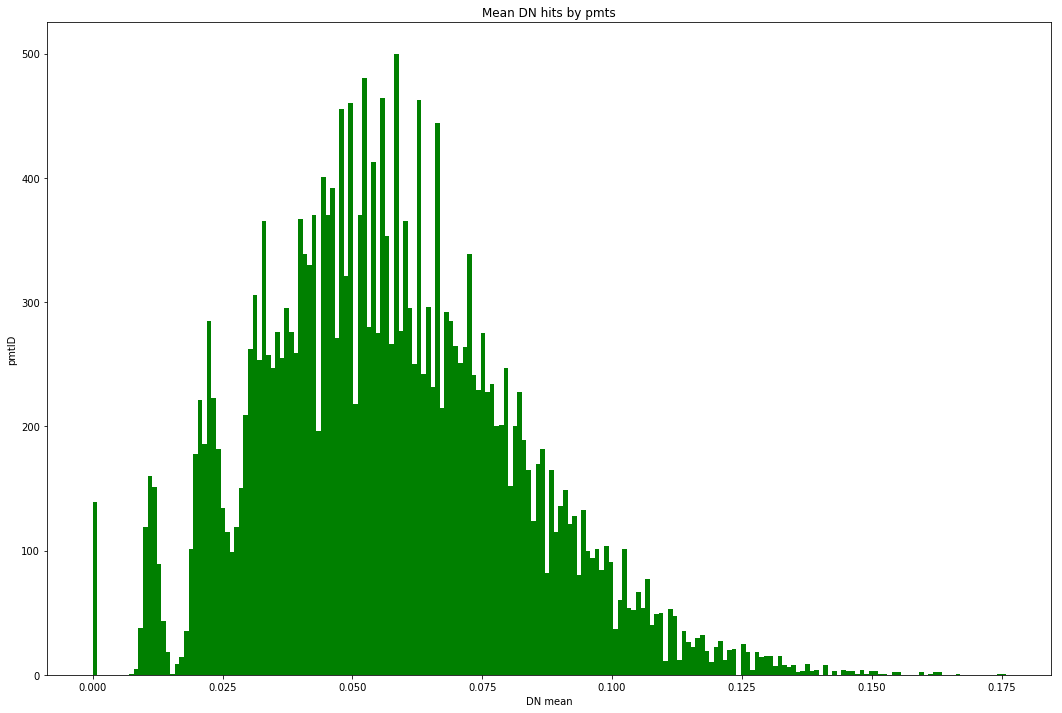

In [38]:
plt.figure(figsize = figSize)
plt.hist(spmtPMTMean['isDN'], bins = 200, color = 'g')
plt.xlabel("DN mean")
plt.ylabel("pmtID")
plt.title('Mean DN hits by pmts')
plt.show()

In [50]:
spmtNumHits = spmt_n_hits

In [53]:
spmtNumHits['round'] = spmtNumHits['nHits'].apply(lambda x:round(x, -1))

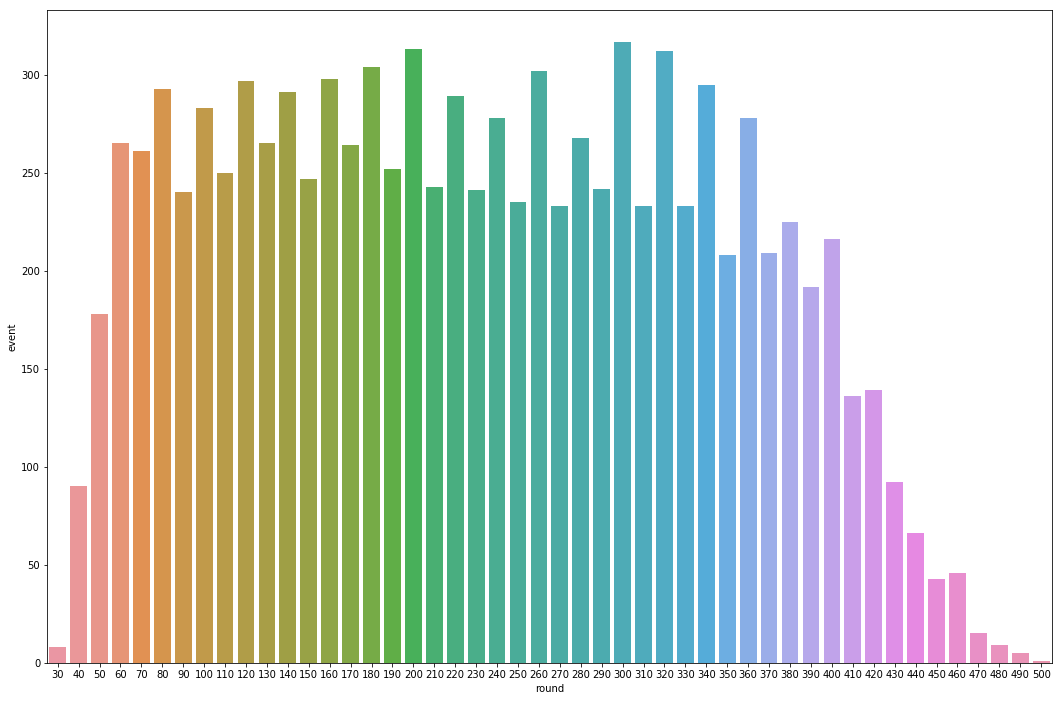

In [56]:
plt.figure(figsize = figSize)
sns.barplot(x = "round", y = "event", data = spmtNumHits.groupby('round', as_index = False)['event'].count())

In [39]:
spmtPMT.head()

,pmtID,isDN,is_DN
0,300000,0.050505,0.05
1,300001,0.084337,0.08
2,300002,0.031579,0.03
3,300003,0.026316,0.03
4,300004,0.044118,0.04


In [40]:
spmtPMT['col'] = spmtPMT.is_DN.apply(lambda x: 1 if x < 0.05 else 1)
pmtPos = pd.merge(spmt_pos, spmtPMT, on = 'pmtID', how = 'inner')

In [41]:
lpmt_hits.head()

,event,hitTime,isDN,pmtID
0,0,249.992615,0,14175
1,0,40.010311,0,17319
2,0,162.123199,0,16882
3,0,51.875614,0,14951
4,0,79.817497,0,10947


In [42]:
eventID = 10000

In [43]:
lpmt_event_hits = lpmt_hits.loc[lpmt_hits['event'] ==  eventID]
spmt_event_hits = spmt_hits.loc[spmt_hits['event'] == eventID]

In [44]:
spmt_event_hits.head()

,event,hitTime,isDN,pmtID
0,10000,98.907349,0,324082
1,10000,40.084866,0,308895
2,10000,31.907373,0,305257
3,10000,171.044754,0,322158
4,10000,202.132889,0,324788


In [45]:
lpmt_hits_values = lpmt_event_hits['pmtID'].values
spmt_hits_values = spmt_event_hits['pmtID'].values

In [90]:
lpmt_hits_mask = []
for t in lpmt_pos.itertuples():
    if t[1] in lpmt_hits_values:
        lpmt_hits_mask.append("r")
    else:
        lpmt_hits_mask.append("y")
        
spmt_hits_mask = []
for t in spmt_pos.itertuples():
    if t[1] in spmt_hits_values:
        spmt_hits_mask.append("r")
    else:
        spmt_hits_mask.append("y")

In [ ]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111, projection='3d')

x = lpmt_pos['pmt_x']
y = lpmt_pos['pmt_y']
z = lpmt_pos['pmt_z']

ax.scatter(x, y, z, c=lpmt_hits_mask, marker='o', s=5, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x = spmt_pos['pmt_x']
y = spmt_pos['pmt_y']
z = spmt_pos['pmt_z']

ax.scatter(x, y, z, c=spmt_hits_mask, marker='o', s=2, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.savefig('PMT.jpg')
plt.show()

In [61]:
spmtPos.head()

,event,hitTime,isDN,pmtID,nHits,pmt_x,pmt_y,pmt_z
0,0,238.278091,0,311819,212,1320.0306,-17951.344,6681.8247
1,73,108.962761,0,311819,362,1320.0306,-17951.344,6681.8247
2,232,97.140427,0,311819,429,1320.0306,-17951.344,6681.8247
3,689,143.792679,0,311819,184,1320.0306,-17951.344,6681.8247
4,723,104.973770,0,311819,300,1320.0306,-17951.344,6681.8247


In [50]:
mask = []
i = 0
for index, row in spmtPos.iterrows():
    if (row['isDN'] == 0):
        if (row['hitTime'] < 120):
            if (row['nHits'] < 300):
                mask.append((0.3, 0.2, 0.3))
            else:
                mask.append((0.6, 0.2, 0.3))
        else:
            mask.append((0.9, 0.2, 0.6))
    else:
        mask.append((0.7, 0.7, 0.8))

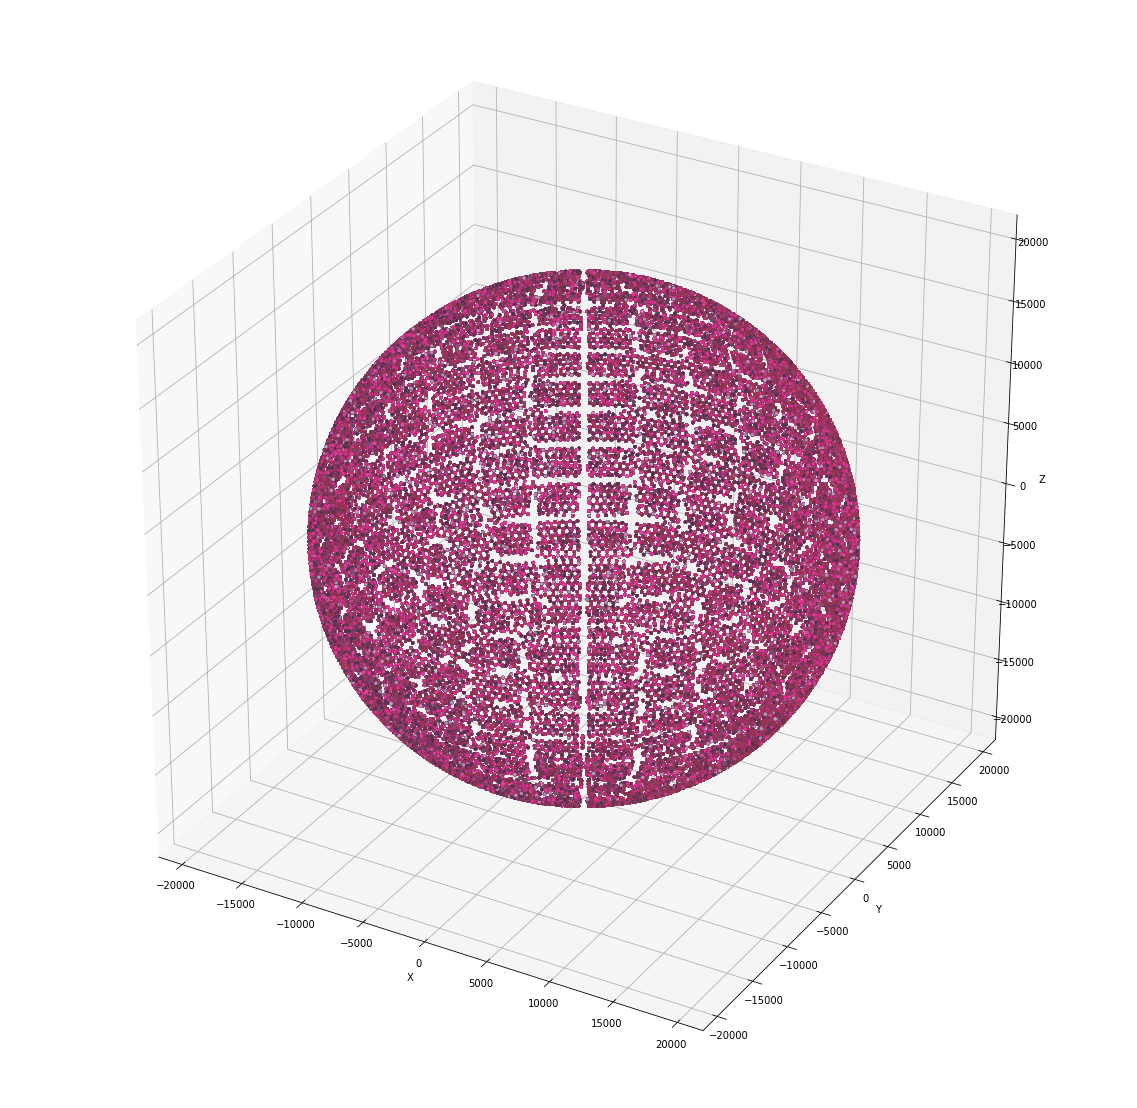

In [51]:
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111, projection='3d')

x = spmtPos['pmt_x']
y = spmtPos['pmt_y']
z = spmtPos['pmt_z']

ax.scatter(x, y, z, c = mask, marker='o', s=5, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [60]:
spmtFull = pd.merge(spmtPos, info, how = 'inner', on = 'event')

In [61]:
print(spmtFull.head())
print(spmtFull.shape)

   event     hitTime  isDN   pmtID  nHits       pmt_x       pmt_y       pmt_z  \
0      0  238.278091     0  311819    212   1320.0306 -17951.3440   6681.8247   
1      0  103.316055     0  307244    212  11640.3910  10284.3125  11286.0200   
2      0  108.034225     0  323230    212  -4579.9067  17968.9140  -4978.2104   
3      0   36.505154     0  320568    212   8443.8740  17097.5120  -2239.6620   
4      0   34.109840     0  316487    212  13795.8930  13232.2390   1794.7690   

          E          R         x          y          z  
0  4.747791  14610.378  8290.779  11995.618  911.74286  
1  4.747791  14610.378  8290.779  11995.618  911.74286  
2  4.747791  14610.378  8290.779  11995.618  911.74286  
3  4.747791  14610.378  8290.779  11995.618  911.74286  
4  4.747791  14610.378  8290.779  11995.618  911.74286  
(2314146, 13)


In [64]:
timeInitHit = spmtFull.groupby('event', as_index = False)['hitTime'].min()
timeInitHit.rename(columns = {'hitTime' : 'initHit'}, inplace = True)
spmtDif = spmtFull.merge(timeInitHit, how = 'inner', on = 'event')

In [65]:
spmtDif.head()

,event,hitTime,isDN,pmtID,nHits,pmt_x,pmt_y,pmt_z,E,R,x,y,z,initHit
0,0,238.278091,0,311819,212,1320.0306,-17951.3440,6681.8247,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285
1,0,103.316055,0,307244,212,11640.3910,10284.3125,11286.0200,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285
2,0,108.034225,0,323230,212,-4579.9067,17968.9140,-4978.2104,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285
3,0,36.505154,0,320568,212,8443.8740,17097.5120,-2239.6620,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285
4,0,34.109840,0,316487,212,13795.8930,13232.2390,1794.7690,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285


In [67]:
spmtDif['diffTime'] = spmtDif['hitTime'] - spmtDif['initHit']

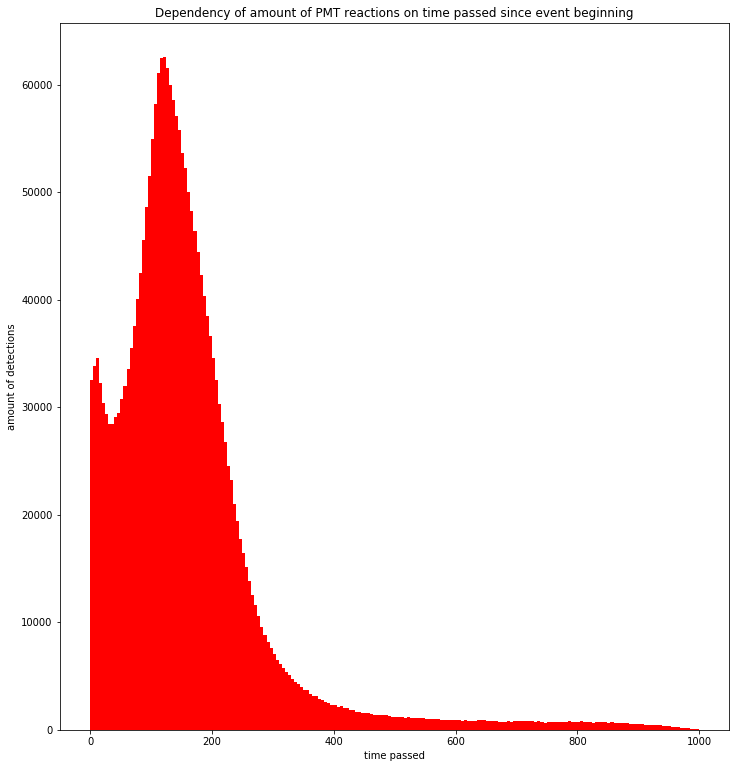

In [70]:
plt.figure(figsize = (12, 13))
plt.hist(spmtDif['diffTime'], bins = 200, color = 'r')
plt.xlabel('time passed')
plt.ylabel('amount of detections')
plt.title('Dependency of amount of PMT reactions on time passed since event beginning')
plt.show()

In [74]:
spmtDifNoNoise = spmtDif.loc[spmtDif['isDN'] == 0]
spmtDifNoNoise.head()

,event,hitTime,isDN,pmtID,nHits,pmt_x,pmt_y,pmt_z,E,R,x,y,z,initHit,diffTime
0,0,238.278091,0,311819,212,1320.0306,-17951.3440,6681.8247,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285,213.654800
1,0,103.316055,0,307244,212,11640.3910,10284.3125,11286.0200,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285,78.692772
2,0,108.034225,0,323230,212,-4579.9067,17968.9140,-4978.2104,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285,83.410942
3,0,36.505154,0,320568,212,8443.8740,17097.5120,-2239.6620,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285,11.881868
4,0,34.109840,0,316487,212,13795.8930,13232.2390,1794.7690,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285,9.486555


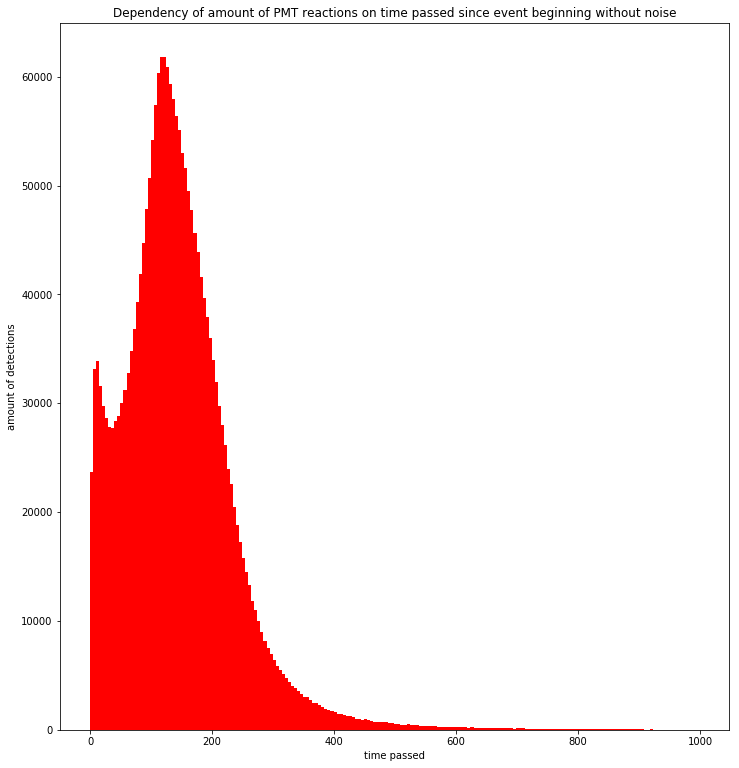

In [77]:
plt.figure(figsize = (12, 13))
plt.hist(spmtDifNoNoise['diffTime'], bins = 200, color = 'r')
plt.xlabel('time passed')
plt.ylabel('amount of detections')
plt.title('Dependency of amount of PMT reactions on time passed since event beginning without noise')
plt.show()